<a href="https://colab.research.google.com/github/jrgosalvez/data255_DL/blob/main/Lab1/Part_2_DL_255_Lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SJSU MSDS 255 DL, Spring 2024
#### Lab 1 - Part 2; Team 15

## Image Classification with DL

**NOTE**: This notebook was optimized for cpu. GPU will require refactoring!

# Step 1

#### Load dataset from Kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
# load kaggle.json file with credentials
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jorgegosalvez","key":"b878e2c8c62c3e1bb3ff187def4312c4"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Source: https://www.kaggle.com/datasets/mdwaquarazam/microorganism-image-classification

Under Settings > select 'Copy API Command'

In [ ]:
!kaggle datasets download -d mdwaquarazam/microorganism-image-classification

 85% 86.0M/101M [00:00<00:00, 175MB/s]
100% 101M/101M [00:00<00:00, 175MB/s] 


In [ ]:
!unzip microorganism-image-classification.zip -d microorganism-image-classification

Archive:  microorganism-image-classification.zip
  inflating: microorganism-image-classification/Micro_Organism/Amoeba/Image_1.jpg  
  inflating: microorganism-image-classification/Micro_Organism/Amoeba/Image_10.jpg  
  inflating: microorganism-image-classification/Micro_Organism/Amoeba/Image_11.jpg  
  inflating: microorganism-image-classification/Micro_Organism/Amoeba/Image_14.jpg  
  inflating: microorganism-image-classification/Micro_Organism/Amoeba/Image_16.jpg  
  inflating: microorganism-image-classification/Micro_Organism/Amoeba/Image_17.jpg  
  inflating: microorganism-image-classification/Micro_Organism/Amoeba/Image_19.jpg  
  inflating: microorganism-image-classification/Micro_Organism/Amoeba/Image_2.jpg  
  inflating: microorganism-image-classification/Micro_Organism/Amoeba/Image_20.png  
  inflating: microorganism-image-classification/Micro_Organism/Amoeba/Image_21.jpg  
  inflating: microorganism-image-classification/Micro_Organism/Amoeba/Image_22.jpg  
  inflating: micro

# Step 2

### Explanations

**Gradient Descent (GC)** = is a convex (U shape) formed by taking the derivative of the error function. Identifying the slope and contining in slope direction (+ / -) until slope equals 0 to find the local minima of the derivative of the loss function finds the optimal weight to minimize loss.

Gradient Desent uses ALL data points at a time (when b=N) where as Stochastic Gradient Descent (SGD) is where b=1 or one random data point at a time. Mini-batch Gradient Desent is when the number of data points (b) is greater than 1, but less than N or all data points.

**Drop out** = using dropout as part of a neural network architecture assigns random connection drop outs based on a defined percent to drop out. By dropping out a percent of random connections in the network, it improves the resiliency of the network because the network has to find alterntive avenues to generate outcomes that mitigate loss. The drop out technique prevents overfitting and is only used on training datasets, never for test or inference.

**Activation Functions** = are the heart of hidden layers. They get a single number and output a single number (scalar in / scalar out). Because not all neural networks are linear, activation functions afford non-linear activation, if they do not non-linear activation functions would simply reduce to linear regression. Six activation functions are popular, Sigmoid, tanh, ReLU, Leaky ReLU, Maxout, and ELU. Of these ReLu is a good default choice. Which activation fucntion to use depends on on the output variable which also affects which loss function to use. Include is a simple table outling what output layer (activation and loss function) to use.

**Output Variable | Output Layer | Loss Function**

* Single number   | Linear       | MSE

* Single probability    | Sigmoid      | Binary cross-entropy

* Vector of n numbers   | Stack of linear functions       | MSE

* Vector of n probabilities   | Softmax       | Categorical cross-entropy


**Back Propagation** = exploits the layer-by-layer architecture of neural networks as an efficient method to compute the gradient of the loss function. This is accomplished by organizing in the form of computational graph that affords incremental calcuation of the gradient one layer at a time using matrix multiplications (perfect for GPUs). In calculating the gradient of a layer to optimize the loss function by adjusting weights across the network. Back prop allows the neural network to iterate forwards and backwards in a repetative pattern adjusting weights based on the gradient of the error fucntion (weights) calculated by taking the partial derivatives and applying the 'chain rule' across the network in an interative fashion until the loss is close to zero. When this happens the network is said to have converged (zero/inconsiquential gains to make additional moves).

**Epochs, Iterations, and Batch Size**


* **Epochs** = one complete pass of an entire training dataset exactly once to update weights.
* **Batch Size** = number of training examples in one iteration. Batch size breaks up the dataset into bite-size chunks.
* **Iterations** = one update of a models weights based on one batch of training data. Iterations are calculated based on the dataset size (number of samples) divided by the batch size. For example, if we have 1,000 images and a batch size of 50, than the number of iterations per epoch is 20.




# Step 3

### Visualize and Summarize Data

In [ ]:
import os

def count_folders_and_objects(directory):
    folders_count = 0
    objects_count = 0

    for root, dirs, files in os.walk(directory):
        folders_count += len(dirs)
        objects_count += len(files)

    return folders_count, objects_count

directory_path = '/content/microorganism-image-classification/Micro_Organism'
folders, objects = count_folders_and_objects(directory_path)
print("Number of folders:", folders)
print("Number of objects:", objects)

Number of folders: 8
Number of objects: 789


In [ ]:
from PIL import Image

# Num pixels in the image (HxW)
img = Image.open('/content/microorganism-image-classification/Micro_Organism/Amoeba/Image_10.jpg')
img.size

(720, 405)

In [ ]:
def check_channels(image_path):
    img = Image.open(image_path)
    # Get the mode of the image, which represents the color mode and number of channels
    mode = img.mode
    # For RGB images, mode will be 'RGB', which indicates 3 channels
    # For grayscale images, mode will be 'L', which indicates 1 channel
    if mode == 'RGB':
        return 3
    elif mode == 'L':
        return 1
    else:
        # Handle other modes if needed
        return None

# Check number of image channels
image_path = '/content/microorganism-image-classification/Micro_Organism/Amoeba/Image_10.jpg'
num_channels = check_channels(image_path)
print('Number of channels:', num_channels)

Number of channels: 3


In [ ]:
# create list of classes from folder names for labels
class_names = os.listdir(directory_path)
num_classes = len(class_names)
print(class_names)
print(f'Num. of classes: {num_classes}')

['Euglena', 'Yeast', 'Rod_bacteria', 'Paramecium', 'Spiral_bacteria', 'Hydra', 'Amoeba', 'Spherical_bacteria']
Num. of classes: 8


In [ ]:
# create list of image files
image_files = [[os.path.join(directory_path, class_name, x)
               for x in os.listdir(os.path.join(directory_path, class_name))]
               for class_name in class_names]

In [ ]:
image_file_list  = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)

In [ ]:
import numpy as np

# split into train, test, validate sets
valid_frac, test_frac = 0.2, 0.3
trainX,trainY = [],[]
valX,valY = [],[]
testX,testY = [],[]

for i in range(num_total):
    rann = np.random.random()
    if rann < valid_frac:
        valX.append(image_file_list[i])
        valY.append(image_label_list[i])
    elif rann < test_frac + valid_frac:
        testX.append(image_file_list[i])
        testY.append(image_label_list[i])
    else:
        trainX.append(image_file_list[i])
        trainY.append(image_label_list[i])

# assign to arrays
trainX=np.array(trainX)
trainY=np.array(trainY)
valX  =np.array(valX)
valY  =np.array(valY)
testX =np.array(testX)
testY =np.array(testY)

print(f'Num. of images: train {len(trainX)}, validate {len(valX)}, test {len(testX)}')

Num. of images: train 386, validate 155, test 248


Class name: Euglena has 168 images


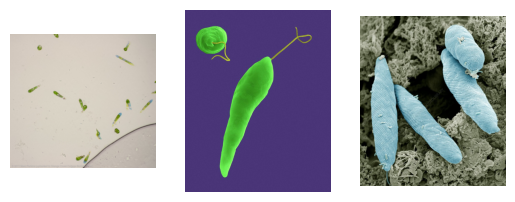


Class name: Yeast has 75 images


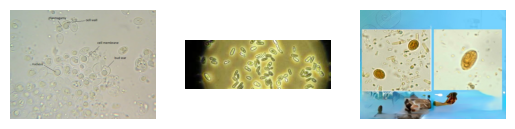


Class name: Rod_bacteria has 85 images


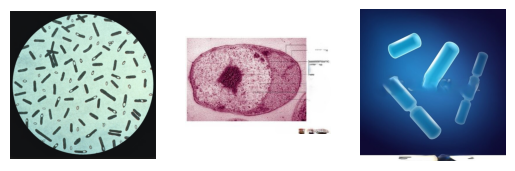


Class name: Paramecium has 152 images


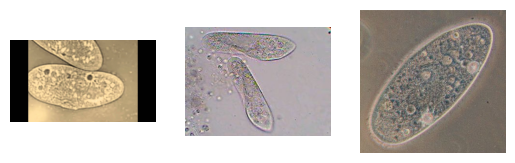


Class name: Spiral_bacteria has 75 images


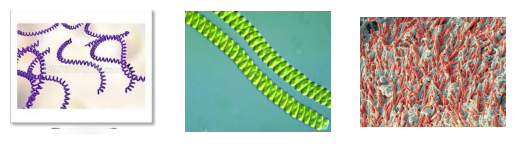


Class name: Hydra has 76 images


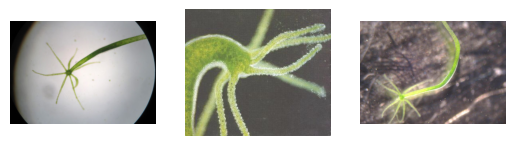


Class name: Amoeba has 72 images


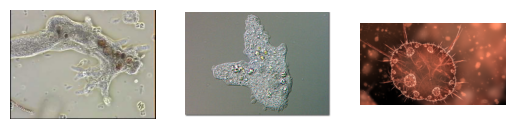


Class name: Spherical_bacteria has 86 images
Error reading /content/microorganism-image-classification/Micro_Organism/Spherical_bacteria/Image_246.png: not a PNG file


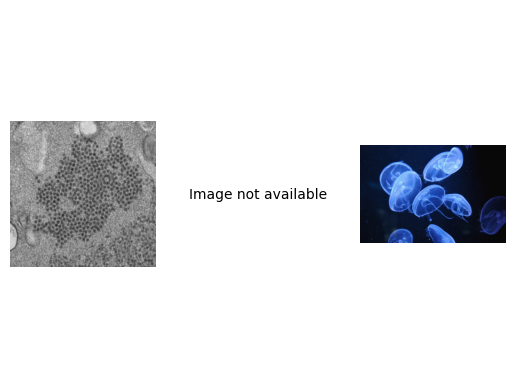

In [ ]:
# Num classes in target variable. Classes, number of images per class, and 3 images per class visualized

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def count_objects_in_folders(directory):
    folders_and_objects_count = {}

    for root, dirs, files in os.walk(directory):
        folder_name = os.path.relpath(root, directory)
        objects_count = len(files)
        folders_and_objects_count[folder_name] = objects_count

        # Display up to three images from the current folder
        if objects_count >= 3:
            images = [f for f in files if f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.png')][:3]  # Assuming images are JPEG or PNG
            img_paths = [os.path.join(root, img) for img in images]
            print(f'Class name: {folder_name} has {objects_count} images')
            display_images_side_by_side(img_paths)
            print()

    return folders_and_objects_count

def display_images_side_by_side(img_paths):
    fig, axs = plt.subplots(1, len(img_paths))
    for i, img_path in enumerate(img_paths):
        try:
            img = mpimg.imread(img_path)
            axs[i].imshow(img)
            axs[i].axis('off')
        except (SyntaxError, OSError) as e:
            print(f"Error reading {img_path}: {e}")
            axs[i].axis('off')
            axs[i].text(0.5, 0.5, "Image not available", horizontalalignment='center', verticalalignment='center', transform=axs[i].transAxes)
    plt.show()

# call function
folders_and_objects = count_objects_in_folders(directory_path)

# Step 4

### Train NN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import PIL

In [ ]:
def check_channels(image_path):
  img = Image.open(image_path)
  # Get the mode of the image, which represents the color mode and number of channels
  mode = img.mode
  # For RGB images, mode will be 'RGB', which indicates 3 channels
  num_channels = 3 if mode == 'RGB' else 1
  return num_channels

In [ ]:
# check channels for training images; should be 3
count = 0
for path in trainX:
  if check_channels(path) == 3: count +=1
print(count)

377


In [ ]:
# Create an empty list to store valid image paths
valid_paths_train = []
valid_paths_val   = []
valid_paths_test  = []

# Filter trainX for images with 3 channels
for path in trainX:
    if check_channels(path) == 3:
        valid_paths_train.append(path)

for path in valX:
    if check_channels(path) == 3:
        valid_paths_val.append(path)

for path in testX:
    if check_channels(path) == 3:
        valid_paths_test.append(path)

# Update trainX with valid paths
trainX = valid_paths_train
valX   = valid_paths_val
testX  = valid_paths_test

print(len(trainX), len(valX), len(testX))

377 148 240


In [ ]:
# Define the neural network architecture. Number of layers and neurons in each layer. NO dropout
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Define custom dataset
class CustomDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        label = self.targets[idx]

        # Open image using PIL
        image = Image.open(image_path)
        #image = Image.fromarray(image_path)

        if self.transform:
            image = self.transform(image)

        # Convert data to PyTorch tensor
        image_tensor = torch.tensor(np.array(image), dtype=torch.float32)

        return image_tensor, label

In [ ]:
# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# validation transformations
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images
])

In [ ]:
# Convert trainX to NumPy array
trainX = np.array(trainX)
valX = np.array(valX)
testX = np.array(testX)

# Convert trainY to NumPy array
trainY = np.array(trainY)
valY = np.array(valY)
testY = np.array(testY)

# Create custom dataset
custom_dataset = CustomDataset(trainX, trainY, transform=transform)
custom_dataset_val   = CustomDataset(valX, valY, transform=val_transform)
custom_dataset_test  = CustomDataset(testX, testY, transform=transform)

print(type(trainX))
print(type(custom_dataset.data))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
# Create data loader (make sure batches align with number of available images)
batch_size = 16
train_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(custom_dataset_val, batch_size=batch_size, num_workers=2, shuffle=False)
test_loader  = DataLoader(custom_dataset_test, batch_size=batch_size, num_workers=2, shuffle=False)

print(train_loader)

In [ ]:
# Initialize the model, loss function, and optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")         # <<< NOTE: Code is optimized for CPU. GPU will require refactoring
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
num_epochs = 10
val_interval = 1  # Perform validation every 1 epoch
f1_scores_train = []  # Track train F1 scores for each epoch
f1_scores_val = []  # Track validation F1 scores for each epoch
train_losses = []  # Track train losses for each epoch
val_losses = []  # Track validation losses for each epoch

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    y_true_train = torch.tensor([], dtype=torch.long, device=device)
    y_pred_train = torch.tensor([], dtype=torch.float32, device=device)

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Concatenate predictions and true labels for computing F1 score later
        y_pred_train = torch.cat([y_pred_train, outputs.detach()], dim=0)
        y_true_train = torch.cat([y_true_train, labels], dim=0)

    train_losses.append(running_loss / len(train_loader))

    # Compute F1 score for training data
    f1_train = f1_score(y_true_train.cpu(), torch.argmax(y_pred_train, axis=1).cpu(), average='macro')
    f1_scores_train.append(f1_train)

    # Validation phase
    if (epoch + 1) % val_interval == 0:
        model.eval()  # Set model to evaluation mode
        val_running_loss = 0.0
        y_true_val = torch.tensor([], dtype=torch.long, device=device)
        y_pred_val = torch.tensor([], dtype=torch.float32, device=device)

        with torch.no_grad():
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item()

                # Concatenate predictions and true labels for computing F1 score later
                y_pred_val = torch.cat([y_pred_val, val_outputs.detach()], dim=0)
                y_true_val = torch.cat([y_true_val, val_labels], dim=0)

        val_losses.append(val_running_loss / len(val_loader))

        # Compute F1 score for validation data
        f1_val = f1_score(y_true_val.cpu(), torch.argmax(y_pred_val, axis=1).cpu(), average='macro')
        f1_scores_val.append(f1_val)

    # Print loss and F1 score at the end of each epoch
    print('Epoch [%d/%d], Train Loss: %.4f, Train F1 Score: %.4f, Validation Loss: %.4f, Validation F1 Score: %.4f' %
          (epoch + 1, num_epochs, train_losses[-1], f1_train, val_losses[-1], f1_val))

print()
print(f'F1 Scores for training each epoch: {f1_scores_train}')
print(f'F1 Scores for validation each epoch: {f1_scores_val}')
print(f'Training losses: {train_losses}')
print(f'Validation losses: {val_losses}')
print('Finished Training')

Epoch [1/10], Train Loss: 4.0286, Train F1 Score: 0.1120, Validation Loss: 2.0545, Validation F1 Score: 0.0657
Epoch [2/10], Train Loss: 1.9138, Train F1 Score: 0.1774, Validation Loss: 2.0286, Validation F1 Score: 0.1296
Epoch [3/10], Train Loss: 1.5775, Train F1 Score: 0.4529, Validation Loss: 1.9576, Validation F1 Score: 0.2544
Epoch [4/10], Train Loss: 1.1543, Train F1 Score: 0.6311, Validation Loss: 2.1822, Validation F1 Score: 0.2150
Epoch [5/10], Train Loss: 0.6550, Train F1 Score: 0.8130, Validation Loss: 2.4318, Validation F1 Score: 0.2134
Epoch [6/10], Train Loss: 0.4161, Train F1 Score: 0.8847, Validation Loss: 2.3674, Validation F1 Score: 0.3064
Epoch [7/10], Train Loss: 0.2063, Train F1 Score: 0.9675, Validation Loss: 2.3558, Validation F1 Score: 0.3103
Epoch [8/10], Train Loss: 0.1483, Train F1 Score: 0.9664, Validation Loss: 2.8509, Validation F1 Score: 0.2580
Epoch [9/10], Train Loss: 0.1338, Train F1 Score: 0.9662, Validation Loss: 2.8424, Validation F1 Score: 0.2537
E

In [ ]:
import matplotlib.pyplot as plt

# Create the figure and axes. Increasing score indicates better performance
def f1_chart(num_epochs, f1_scores_train, f1_scores_val):
  fig = plt.figure()
  ax = fig.add_axes([0, 0, 1, 1])

  # Plot the F1 scores for training and validation sets
  ax.plot(range(1, num_epochs + 1), f1_scores_train, label="Train")
  # Plot the F1 scores for training and validation sets
  ax.plot(range(1, num_epochs + 1), f1_scores_val, label="Validation")

  # Set the title and axis labels
  ax.set_title("F1 Scores by Epoch")
  ax.set_xlabel("Epoch")
  ax.set_ylabel("F1_train Score")
  ax.set_ylabel("F1_val Score")

  # Add a legend
  ax.legend()

  # Set the x-axis ticks to whole integer intervals
  ax.set_xticks(range(1, num_epochs + 1))

  # Display the plot
  plt.show()

In [ ]:
def loss_chart(num_epochs, train, val):
  fig = plt.figure()
  ax = fig.add_axes([0, 0, 1, 1])

  # Plot the F1 scores for training and validation sets
  ax.plot(range(1, num_epochs + 1), train, label="Train")
  # Plot the F1 scores for training and validation sets
  ax.plot(range(1, num_epochs + 1), val, label="Validation")

  # Set the title and axis labels
  ax.set_title("Loss by Epoch")
  ax.set_xlabel("Epoch")
  ax.set_ylabel("Train Loss")
  ax.set_ylabel("Val Loss")

  # Add a legend
  ax.legend()

  # Set the x-axis ticks to whole integer intervals
  ax.set_xticks(range(1, num_epochs + 1))

  # Display the plot
  plt.show()

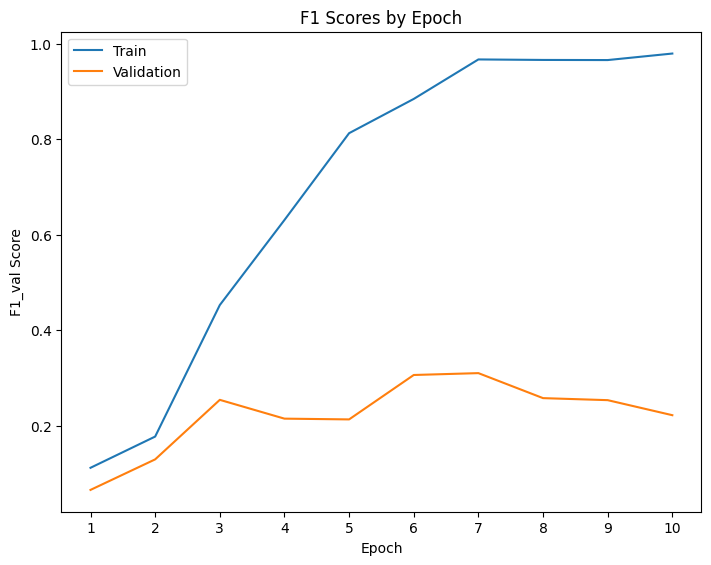

In [ ]:
# Graph f1 score vs epoch for training and validation
f1_chart(num_epochs, f1_scores_train, f1_scores_val)

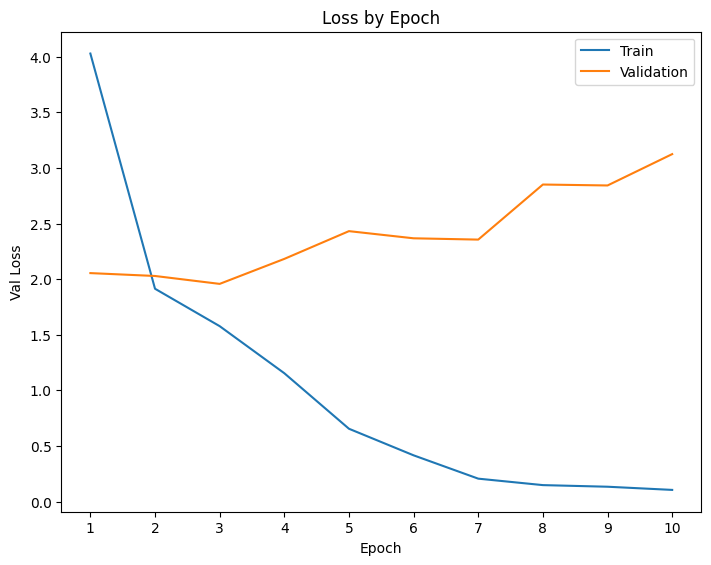

In [ ]:
# Graph f1 score vs epoch for training and validation
loss_chart(num_epochs, train_losses, val_losses)

In [ ]:
# Try different activation functions
import torch.nn.functional as F

class Net_af(nn.Module):
    def __init__(self):
        super(Net_af, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # New convolutional layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 28 * 28, 256)  # Adjusted fully connected layer input size
        self.fc2 = nn.Linear(256, 128)           # New fully connected layer
        self.fc3 = nn.Linear(128, num_classes)   # New fully connected layer

    def forward(self, x):
        x = self.pool(F.sigmoid(self.conv1(x)))  # Using Sigmoid activation function
        x = self.pool(F.tanh(self.conv2(x)))     # Using Tanh activation function
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = F.relu(self.fc1(x))                  # ReLU activation function for the first fully connected layer
        x = F.relu(self.fc2(x))                  # ReLU activation function for the second fully connected layer
        x = self.fc3(x)
        return x

In [ ]:
model_af = Net_af().to(device)
optimizer = optim.Adam(model_af.parameters(), lr=0.001)

In [ ]:
val_interval = 1  # Perform validation every 1 epoch
f1_scores_train_af = []  # Track train F1 scores for each epoch
f1_scores_val_af = []  # Track validation F1 scores for each epoch
train_losses_af = []  # Track train losses for each epoch
val_losses_af = []  # Track validation losses for each epoch

for epoch in range(num_epochs):
    running_loss = 0.0
    model_af.train()
    y_true_train = torch.tensor([], dtype=torch.long, device=device)
    y_pred_train = torch.tensor([], dtype=torch.float32, device=device)

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model_af(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Concatenate predictions and true labels for computing F1 score later
        y_pred_train = torch.cat([y_pred_train, outputs.detach()], dim=0)
        y_true_train = torch.cat([y_true_train, labels], dim=0)

    train_losses_af.append(running_loss / len(train_loader))

    # Compute F1 score for training data
    f1_train = f1_score(y_true_train.cpu(), torch.argmax(y_pred_train, axis=1).cpu(), average='macro')
    f1_scores_train_af.append(f1_train)

    # Validation phase
    if (epoch + 1) % val_interval == 0:
        model_af.eval()  # Set model to evaluation mode
        val_running_loss = 0.0
        y_true_val = torch.tensor([], dtype=torch.long, device=device)
        y_pred_val = torch.tensor([], dtype=torch.float32, device=device)

        with torch.no_grad():
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                val_outputs = model_af(val_images)
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item()

                # Concatenate predictions and true labels for computing F1 score later
                y_pred_val = torch.cat([y_pred_val, val_outputs.detach()], dim=0)
                y_true_val = torch.cat([y_true_val, val_labels], dim=0)

        val_losses_af.append(val_running_loss / len(val_loader))

        # Compute F1 score for validation data
        f1_val = f1_score(y_true_val.cpu(), torch.argmax(y_pred_val, axis=1).cpu(), average='macro')
        f1_scores_val_af.append(f1_val)

    # Print loss and F1 score at the end of each epoch
    print('Epoch [%d/%d], Train Loss: %.4f, Train F1 Score: %.4f, Validation Loss: %.4f, Validation F1 Score: %.4f' %
          (epoch + 1, num_epochs, train_losses_af[-1], f1_train, val_losses_af[-1], f1_val))

print()
print(f'F1 Scores for training each epoch: {f1_scores_train_af}')
print(f'F1 Scores for validation each epoch: {f1_scores_val_af}')
print(f'Training losses: {train_losses_af}')
print(f'Validation losses: {val_losses_af}')
print('Finished Training')

Epoch [1/10], Train Loss: 2.0621, Train F1 Score: 0.0698, Validation Loss: 2.0655, Validation F1 Score: 0.0398
Epoch [2/10], Train Loss: 2.0409, Train F1 Score: 0.0482, Validation Loss: 2.0737, Validation F1 Score: 0.0398
Epoch [3/10], Train Loss: 2.0205, Train F1 Score: 0.0482, Validation Loss: 2.0567, Validation F1 Score: 0.0398
Epoch [4/10], Train Loss: 2.0148, Train F1 Score: 0.0609, Validation Loss: 2.0680, Validation F1 Score: 0.0522
Epoch [5/10], Train Loss: 2.0411, Train F1 Score: 0.0486, Validation Loss: 2.2503, Validation F1 Score: 0.0398
Epoch [6/10], Train Loss: 1.9884, Train F1 Score: 0.0808, Validation Loss: 2.0496, Validation F1 Score: 0.0398
Epoch [7/10], Train Loss: 1.9643, Train F1 Score: 0.0947, Validation Loss: 2.0080, Validation F1 Score: 0.0701
Epoch [8/10], Train Loss: 1.9171, Train F1 Score: 0.0804, Validation Loss: 2.0543, Validation F1 Score: 0.0765
Epoch [9/10], Train Loss: 1.8930, Train F1 Score: 0.1031, Validation Loss: 1.9924, Validation F1 Score: 0.0887
E

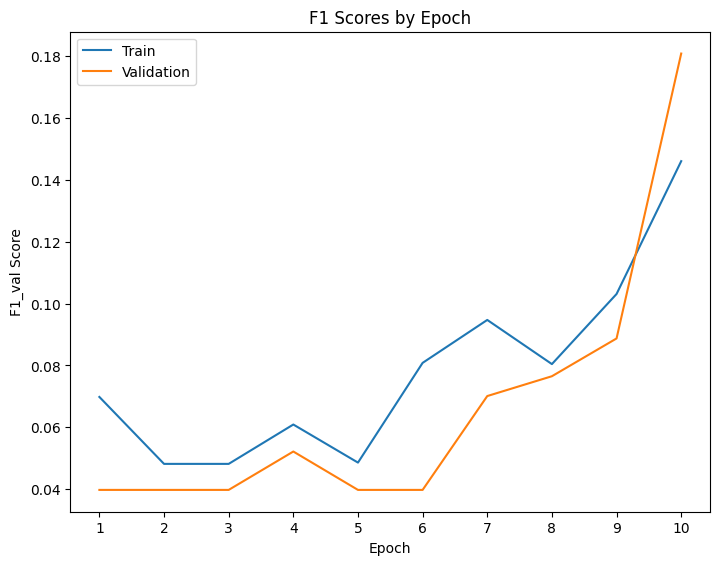

In [ ]:
f1_chart(num_epochs, f1_scores_train_af, f1_scores_val_af)

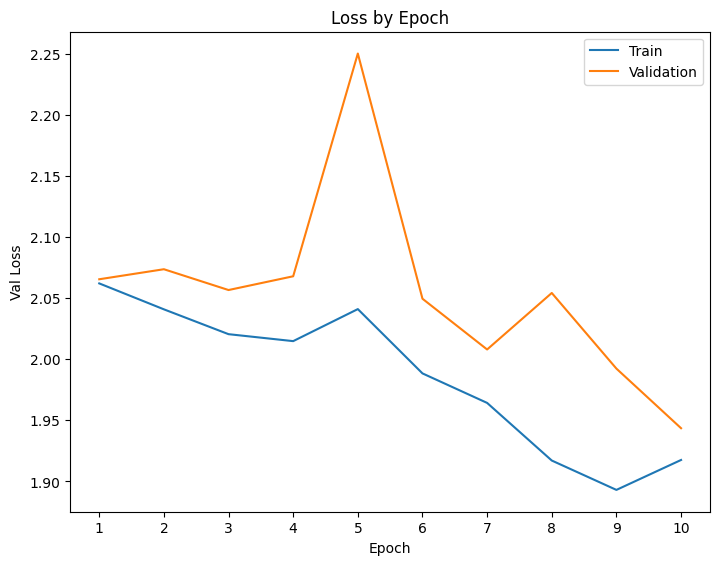

In [ ]:
loss_chart(num_epochs, train_losses_af, val_losses_af)

In [ ]:
# Tried dropout on first model at 25% dropout, it was not complex enough to find patterns, so added complexity to first model
class Net_do(nn.Module):
    def __init__(self, num_classes=8):
        super(Net_do, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # Increased out_channels
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) # Increased out_channels
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1) # New convolutional layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)  # Adjusted fully connected layer input size
        self.fc2 = nn.Linear(256, 128)            # New fully connected layer
        self.fc3 = nn.Linear(128, num_classes)

        self.dropout = nn.Dropout(p=0.25)  # Dropout probability set to 0.5 and 0.25; 0.5 performed poorly, but 0.25 performed better

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)  # Dropout after the first convolutional layer
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)  # Dropout after the second convolutional layer
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)  # Dropout after the third convolutional layer
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Dropout after the first fully connected layer
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  # Dropout after the second fully connected layer
        x = self.fc3(x)
        return x

In [ ]:
model_do = Net_do().to(device)
optimizer = optim.Adam(model_do.parameters(), lr=0.001)

In [ ]:
val_interval = 1  # Perform validation every 1 epoch
f1_scores_train_do = []  # Track train F1 scores for each epoch
f1_scores_val_do = []  # Track validation F1 scores for each epoch
train_losses_do = []  # Track train losses for each epoch
val_losses_do = []  # Track validation losses for each epoch

for epoch in range(num_epochs):
    running_loss = 0.0
    model_do.train()
    y_true_train = torch.tensor([], dtype=torch.long, device=device)
    y_pred_train = torch.tensor([], dtype=torch.float32, device=device)

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model_do(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Concatenate predictions and true labels for computing F1 score later
        y_pred_train = torch.cat([y_pred_train, outputs.detach()], dim=0)
        y_true_train = torch.cat([y_true_train, labels], dim=0)

    train_losses_do.append(running_loss / len(train_loader))

    # Compute F1 score for training data
    f1_train = f1_score(y_true_train.cpu(), torch.argmax(y_pred_train, axis=1).cpu(), average='macro')
    f1_scores_train_do.append(f1_train)

    # Validation phase
    if (epoch + 1) % val_interval == 0:
        model_do.eval()  # Set model to evaluation mode
        val_running_loss = 0.0
        y_true_val = torch.tensor([], dtype=torch.long, device=device)
        y_pred_val = torch.tensor([], dtype=torch.float32, device=device)

        with torch.no_grad():
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                val_outputs = model_do(val_images)
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item()

                # Concatenate predictions and true labels for computing F1 score later
                y_pred_val = torch.cat([y_pred_val, val_outputs.detach()], dim=0)
                y_true_val = torch.cat([y_true_val, val_labels], dim=0)

        val_losses_do.append(val_running_loss / len(val_loader))

        # Compute F1 score for validation data
        f1_val = f1_score(y_true_val.cpu(), torch.argmax(y_pred_val, axis=1).cpu(), average='macro')
        f1_scores_val_do.append(f1_val)

    # Print loss and F1 score at the end of each epoch
    print('Epoch [%d/%d], Train Loss: %.4f, Train F1 Score: %.4f, Validation Loss: %.4f, Validation F1 Score: %.4f' %
          (epoch + 1, num_epochs, train_losses_do[-1], f1_train, val_losses_do[-1], f1_val))

print()
print(f'F1 Scores for training each epoch: {f1_scores_train_do}')
print(f'F1 Scores for validation each epoch: {f1_scores_val_do}')
print(f'Training losses: {train_losses_do}')
print(f'Validation losses: {val_losses_do}')
print('Finished Training')

Epoch [1/10], Train Loss: 2.2382, Train F1 Score: 0.0760, Validation Loss: 2.0796, Validation F1 Score: 0.0398
Epoch [2/10], Train Loss: 1.9900, Train F1 Score: 0.0521, Validation Loss: 1.9660, Validation F1 Score: 0.0398
Epoch [3/10], Train Loss: 1.9616, Train F1 Score: 0.0521, Validation Loss: 1.9899, Validation F1 Score: 0.0398
Epoch [4/10], Train Loss: 1.9351, Train F1 Score: 0.0587, Validation Loss: 1.9713, Validation F1 Score: 0.0398
Epoch [5/10], Train Loss: 1.9169, Train F1 Score: 0.0547, Validation Loss: 1.9168, Validation F1 Score: 0.0398
Epoch [6/10], Train Loss: 1.8734, Train F1 Score: 0.0768, Validation Loss: 1.9126, Validation F1 Score: 0.0478
Epoch [7/10], Train Loss: 1.8571, Train F1 Score: 0.1373, Validation Loss: 1.9227, Validation F1 Score: 0.1034
Epoch [8/10], Train Loss: 1.8077, Train F1 Score: 0.1394, Validation Loss: 1.9444, Validation F1 Score: 0.1867
Epoch [9/10], Train Loss: 1.7817, Train F1 Score: 0.1971, Validation Loss: 1.8795, Validation F1 Score: 0.1512
E

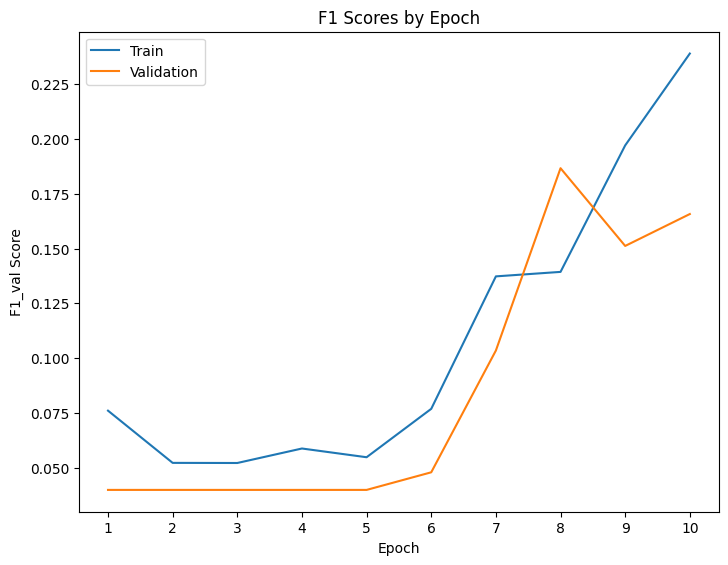

In [ ]:
f1_chart(num_epochs, f1_scores_train_do, f1_scores_val_do)

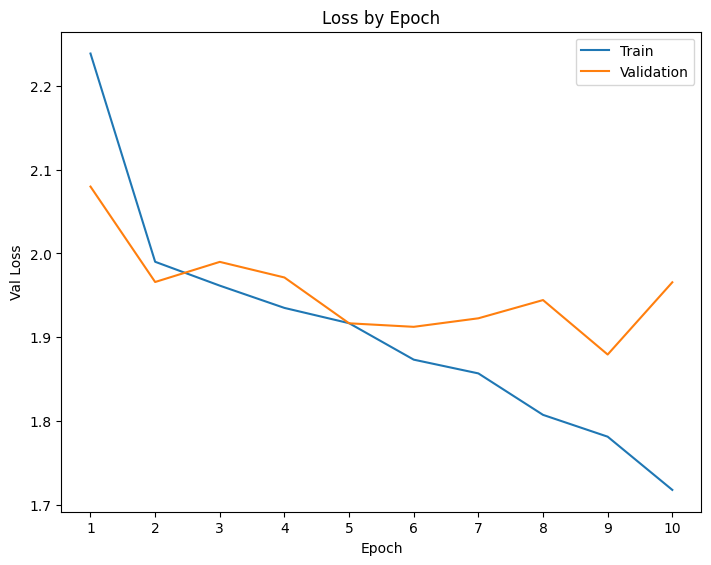

In [ ]:
loss_chart(num_epochs, train_losses_do, val_losses_do)

In [ ]:
# Tried dropout on first model at 50% dropout
class Net_do_half(nn.Module):
    def __init__(self, num_classes=8):
        super(Net_do_half, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # Increased out_channels
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) # Increased out_channels
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1) # New convolutional layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)  # Adjusted fully connected layer input size
        self.fc2 = nn.Linear(256, 128)            # New fully connected layer
        self.fc3 = nn.Linear(128, num_classes)

        self.dropout = nn.Dropout(p=0.25)  # Dropout probability set to 0.5; performed poorly

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)  # Dropout after the first convolutional layer
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)  # Dropout after the second convolutional layer
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)  # Dropout after the third convolutional layer
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Dropout after the first fully connected layer
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  # Dropout after the second fully connected layer
        x = self.fc3(x)
        return x

In [ ]:
model_do_half = Net_do_half().to(device)
optimizer = optim.Adam(model_do_half.parameters(), lr=0.001)

In [ ]:
val_interval = 1  # Perform validation every 1 epoch
f1_scores_train_do_half = []  # Track train F1 scores for each epoch
f1_scores_val_do_half = []  # Track validation F1 scores for each epoch
train_losses_do_half = []  # Track train losses for each epoch
val_losses_do_half = []  # Track validation losses for each epoch

for epoch in range(num_epochs):
    running_loss = 0.0
    model_do_half.train()
    y_true_train = torch.tensor([], dtype=torch.long, device=device)
    y_pred_train = torch.tensor([], dtype=torch.float32, device=device)

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model_do_half(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Concatenate predictions and true labels for computing F1 score later
        y_pred_train = torch.cat([y_pred_train, outputs.detach()], dim=0)
        y_true_train = torch.cat([y_true_train, labels], dim=0)

    train_losses_do_half.append(running_loss / len(train_loader))

    # Compute F1 score for training data
    f1_train = f1_score(y_true_train.cpu(), torch.argmax(y_pred_train, axis=1).cpu(), average='macro')
    f1_scores_train_do_half.append(f1_train)

    # Validation phase
    if (epoch + 1) % val_interval == 0:
        model_do_half.eval()  # Set model to evaluation mode
        val_running_loss = 0.0
        y_true_val = torch.tensor([], dtype=torch.long, device=device)
        y_pred_val = torch.tensor([], dtype=torch.float32, device=device)

        with torch.no_grad():
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                val_outputs = model_do_half(val_images)
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item()

                # Concatenate predictions and true labels for computing F1 score later
                y_pred_val = torch.cat([y_pred_val, val_outputs.detach()], dim=0)
                y_true_val = torch.cat([y_true_val, val_labels], dim=0)

        val_losses_do_half.append(val_running_loss / len(val_loader))

        # Compute F1 score for validation data
        f1_val = f1_score(y_true_val.cpu(), torch.argmax(y_pred_val, axis=1).cpu(), average='macro')
        f1_scores_val_do_half.append(f1_val)

    # Print loss and F1 score at the end of each epoch
    print('Epoch [%d/%d], Train Loss: %.4f, Train F1 Score: %.4f, Validation Loss: %.4f, Validation F1 Score: %.4f' %
          (epoch + 1, num_epochs, train_losses_do_half[-1], f1_train, val_losses_do_half[-1], f1_val))

print()
print(f'F1 Scores for training each epoch: {f1_scores_train_do_half}')
print(f'F1 Scores for validation each epoch: {f1_scores_val_do_half}')
print(f'Training losses: {train_losses_do_half}')
print(f'Validation losses: {val_losses_do_half}')
print('Finished Training')

Epoch [1/10], Train Loss: 2.3213, Train F1 Score: 0.0728, Validation Loss: 2.0555, Validation F1 Score: 0.0398
Epoch [2/10], Train Loss: 2.0039, Train F1 Score: 0.0510, Validation Loss: 2.0300, Validation F1 Score: 0.0398
Epoch [3/10], Train Loss: 2.0038, Train F1 Score: 0.0473, Validation Loss: 1.9898, Validation F1 Score: 0.0398
Epoch [4/10], Train Loss: 1.9430, Train F1 Score: 0.0481, Validation Loss: 1.9485, Validation F1 Score: 0.0398
Epoch [5/10], Train Loss: 1.9279, Train F1 Score: 0.0771, Validation Loss: 1.9284, Validation F1 Score: 0.0659
Epoch [6/10], Train Loss: 1.8802, Train F1 Score: 0.1136, Validation Loss: 1.9707, Validation F1 Score: 0.1074
Epoch [7/10], Train Loss: 1.8453, Train F1 Score: 0.1105, Validation Loss: 1.9101, Validation F1 Score: 0.1397
Epoch [8/10], Train Loss: 1.8155, Train F1 Score: 0.1712, Validation Loss: 1.9111, Validation F1 Score: 0.1297
Epoch [9/10], Train Loss: 1.7623, Train F1 Score: 0.1693, Validation Loss: 1.9438, Validation F1 Score: 0.1624
E

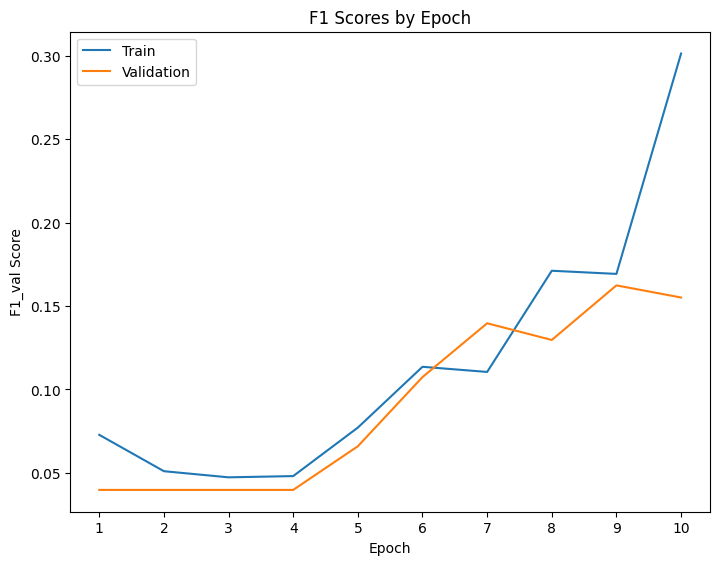

In [ ]:
f1_chart(num_epochs, f1_scores_train_do_half, f1_scores_val_do_half)

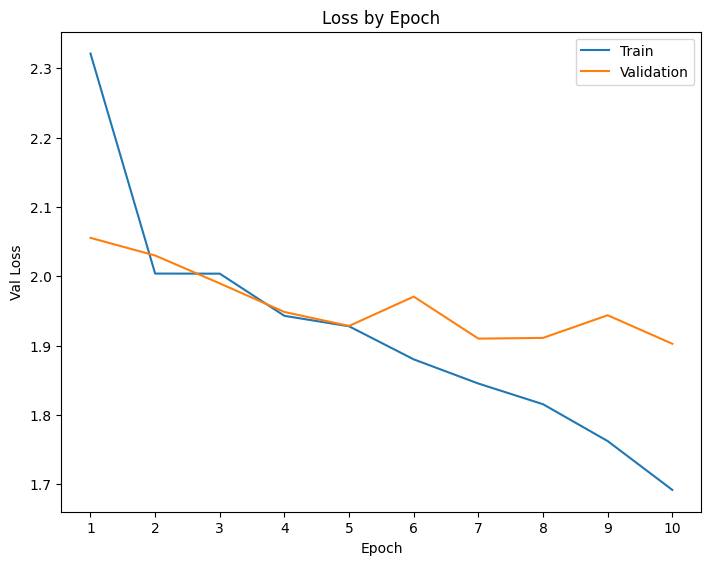

In [ ]:
loss_chart(num_epochs, train_losses_do_half, val_losses_do_half)

In [ ]:
# Try different regularizations (not dropout)
class Net_reg(nn.Module):
    def __init__(self, num_classes=8, weight_decay=1e-5):
        super(Net_reg, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

        self.weight_decay = weight_decay  # added regularization

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# regularize
    def l2_regularization_loss(self):
        l2_loss = 0.0
        for param in self.parameters():
            l2_loss += torch.norm(param)
        return self.weight_decay * l2_loss

In [ ]:
model_reg = Net_reg().to(device)
optimizer = optim.Adam(model_reg.parameters(), lr=0.001)

In [ ]:
val_interval = 1  # Perform validation every 1 epoch
f1_scores_train_reg = []  # Track train F1 scores for each epoch
f1_scores_val_reg = []  # Track validation F1 scores for each epoch
train_losses_reg = []  # Track train losses for each epoch
val_losses_reg = []  # Track validation losses for each epoch

for epoch in range(num_epochs):
    running_loss = 0.0
    model_reg.train()
    y_true_train = torch.tensor([], dtype=torch.long, device=device)
    y_pred_train = torch.tensor([], dtype=torch.float32, device=device)

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model_reg(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Concatenate predictions and true labels for computing F1 score later
        y_pred_train = torch.cat([y_pred_train, outputs.detach()], dim=0)
        y_true_train = torch.cat([y_true_train, labels], dim=0)

    train_losses_reg.append(running_loss / len(train_loader))

    # Compute F1 score for training data
    f1_train = f1_score(y_true_train.cpu(), torch.argmax(y_pred_train, axis=1).cpu(), average='macro')
    f1_scores_train_reg.append(f1_train)

    # Validation phase
    if (epoch + 1) % val_interval == 0:
        model_reg.eval()  # Set model to evaluation mode
        val_running_loss = 0.0
        y_true_val = torch.tensor([], dtype=torch.long, device=device)
        y_pred_val = torch.tensor([], dtype=torch.float32, device=device)

        with torch.no_grad():
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                val_outputs = model_reg(val_images)
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item()

                # Concatenate predictions and true labels for computing F1 score later
                y_pred_val = torch.cat([y_pred_val, val_outputs.detach()], dim=0)
                y_true_val = torch.cat([y_true_val, val_labels], dim=0)

        val_losses_reg.append(val_running_loss / len(val_loader))

        # Compute F1 score for validation data
        f1_val = f1_score(y_true_val.cpu(), torch.argmax(y_pred_val, axis=1).cpu(), average='macro')
        f1_scores_val_reg.append(f1_val)

    # Print loss and F1 score at the end of each epoch
    print('Epoch [%d/%d], Train Loss: %.4f, Train F1 Score: %.4f, Validation Loss: %.4f, Validation F1 Score: %.4f' %
          (epoch + 1, num_epochs, train_losses_reg[-1], f1_train, val_losses_reg[-1], f1_val))

print()
print(f'F1 Scores for training each epoch: {f1_scores_train_reg}')
print(f'F1 Scores for validation each epoch: {f1_scores_val_reg}')
print(f'Training losses: {train_losses_reg}')
print(f'Validation losses: {val_losses_reg}')
print('Finished Training')

Epoch [1/10], Train Loss: 2.1115, Train F1 Score: 0.1066, Validation Loss: 2.0474, Validation F1 Score: 0.0398
Epoch [2/10], Train Loss: 1.9714, Train F1 Score: 0.1010, Validation Loss: 1.9569, Validation F1 Score: 0.1337
Epoch [3/10], Train Loss: 1.9510, Train F1 Score: 0.1150, Validation Loss: 1.9076, Validation F1 Score: 0.1871
Epoch [4/10], Train Loss: 1.8337, Train F1 Score: 0.1908, Validation Loss: 1.8740, Validation F1 Score: 0.0986
Epoch [5/10], Train Loss: 1.7095, Train F1 Score: 0.2172, Validation Loss: 2.0955, Validation F1 Score: 0.1911
Epoch [6/10], Train Loss: 1.5934, Train F1 Score: 0.3131, Validation Loss: 2.0942, Validation F1 Score: 0.1635
Epoch [7/10], Train Loss: 1.4104, Train F1 Score: 0.4424, Validation Loss: 1.9546, Validation F1 Score: 0.2419
Epoch [8/10], Train Loss: 1.1228, Train F1 Score: 0.5683, Validation Loss: 2.4205, Validation F1 Score: 0.2246
Epoch [9/10], Train Loss: 0.8273, Train F1 Score: 0.7244, Validation Loss: 2.4556, Validation F1 Score: 0.2360
E

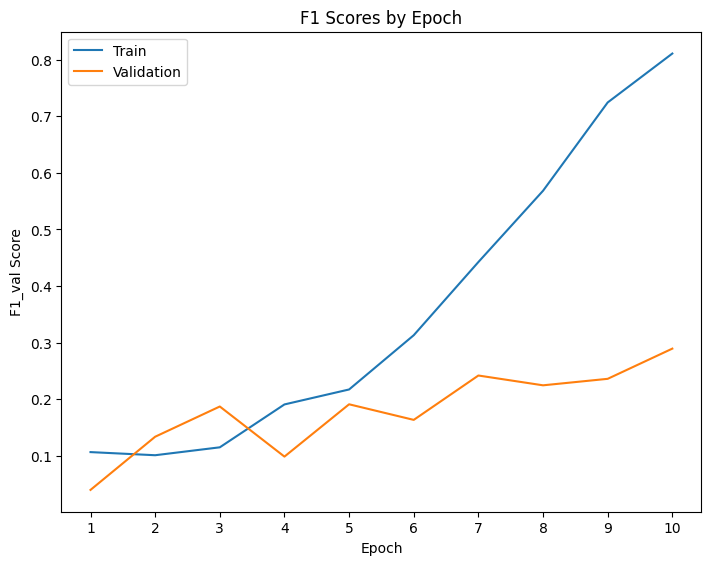

In [ ]:
f1_chart(num_epochs, f1_scores_train_reg, f1_scores_val_reg)

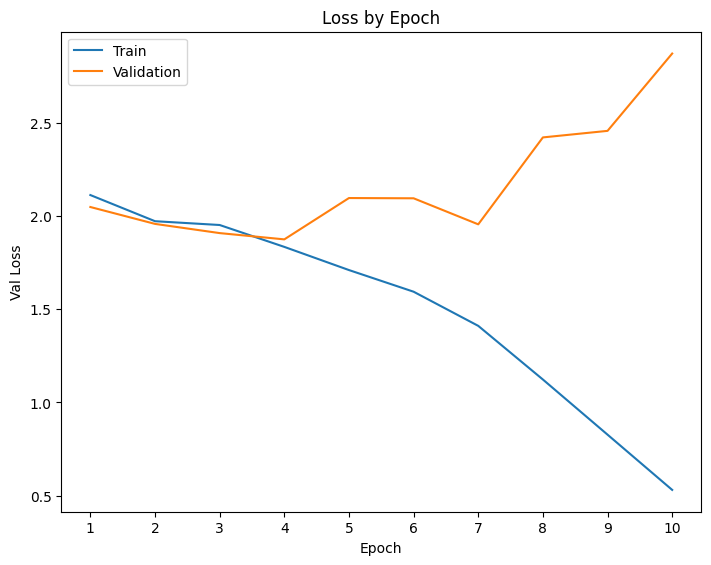

In [ ]:
loss_chart(num_epochs, train_losses_reg, val_losses_reg)

In [ ]:
# Try differnt optimiation algos (GD, SGD, Adam, etc.)
model_opt = Net_reg().to(device)
optimizer = optim.SGD(model_opt.parameters(), lr=0.001)

In [ ]:
val_interval = 1  # Perform validation every 1 epoch
f1_scores_train_opt = []  # Track train F1 scores for each epoch
f1_scores_val_opt = []  # Track validation F1 scores for each epoch
train_losses_opt = []  # Track train losses for each epoch
val_losses_opt = []  # Track validation losses for each epoch

for epoch in range(num_epochs):
    running_loss = 0.0
    model_opt.train()
    y_true_train = torch.tensor([], dtype=torch.long, device=device)
    y_pred_train = torch.tensor([], dtype=torch.float32, device=device)

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model_opt(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Concatenate predictions and true labels for computing F1 score later
        y_pred_train = torch.cat([y_pred_train, outputs.detach()], dim=0)
        y_true_train = torch.cat([y_true_train, labels], dim=0)

    train_losses_opt.append(running_loss / len(train_loader))

    # Compute F1 score for training data
    f1_train = f1_score(y_true_train.cpu(), torch.argmax(y_pred_train, axis=1).cpu(), average='macro')
    f1_scores_train_opt.append(f1_train)

    # Validation phase
    if (epoch + 1) % val_interval == 0:
        model_opt.eval()  # Set model to evaluation mode
        val_running_loss = 0.0
        y_true_val = torch.tensor([], dtype=torch.long, device=device)
        y_pred_val = torch.tensor([], dtype=torch.float32, device=device)

        with torch.no_grad():
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                val_outputs = model_opt(val_images)
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item()

                # Concatenate predictions and true labels for computing F1 score later
                y_pred_val = torch.cat([y_pred_val, val_outputs.detach()], dim=0)
                y_true_val = torch.cat([y_true_val, val_labels], dim=0)

        val_losses_opt.append(val_running_loss / len(val_loader))

        # Compute F1 score for validation data
        f1_val = f1_score(y_true_val.cpu(), torch.argmax(y_pred_val, axis=1).cpu(), average='macro')
        f1_scores_val_opt.append(f1_val)

    # Print loss and F1 score at the end of each epoch
    print('Epoch [%d/%d], Train Loss: %.4f, Train F1 Score: %.4f, Validation Loss: %.4f, Validation F1 Score: %.4f' %
          (epoch + 1, num_epochs, train_losses_opt[-1], f1_train, val_losses_opt[-1], f1_val))

print()
print(f'F1 Scores for training each epoch: {f1_scores_train_opt}')
print(f'F1 Scores for validation each epoch: {f1_scores_val_opt}')
print(f'Training losses: {train_losses_opt}')
print(f'Validation losses: {val_losses_opt}')
print('Finished Training')

Epoch [1/10], Train Loss: 2.0772, Train F1 Score: 0.0588, Validation Loss: 2.0745, Validation F1 Score: 0.0398
Epoch [2/10], Train Loss: 2.0672, Train F1 Score: 0.0482, Validation Loss: 2.0711, Validation F1 Score: 0.0398
Epoch [3/10], Train Loss: 2.0596, Train F1 Score: 0.0482, Validation Loss: 2.0689, Validation F1 Score: 0.0398
Epoch [4/10], Train Loss: 2.0518, Train F1 Score: 0.0482, Validation Loss: 2.0672, Validation F1 Score: 0.0398
Epoch [5/10], Train Loss: 2.0456, Train F1 Score: 0.0482, Validation Loss: 2.0661, Validation F1 Score: 0.0398
Epoch [6/10], Train Loss: 2.0412, Train F1 Score: 0.0482, Validation Loss: 2.0658, Validation F1 Score: 0.0398
Epoch [7/10], Train Loss: 2.0352, Train F1 Score: 0.0482, Validation Loss: 2.0650, Validation F1 Score: 0.0398
Epoch [8/10], Train Loss: 2.0329, Train F1 Score: 0.0482, Validation Loss: 2.0653, Validation F1 Score: 0.0398
Epoch [9/10], Train Loss: 2.0278, Train F1 Score: 0.0482, Validation Loss: 2.0654, Validation F1 Score: 0.0398
E

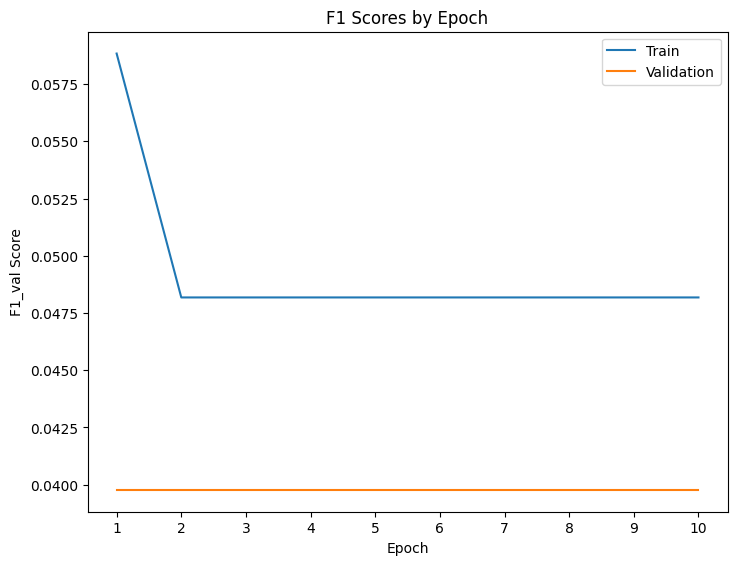

In [ ]:
f1_chart(num_epochs, f1_scores_train_opt, f1_scores_val_opt)

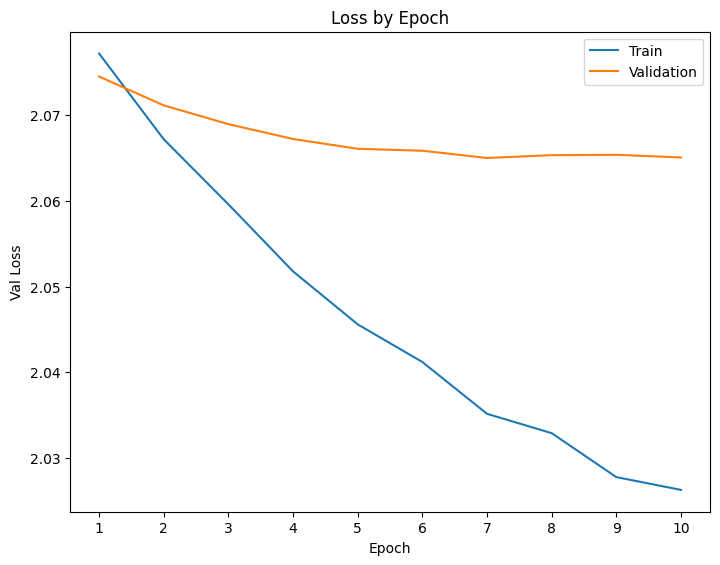

In [ ]:
loss_chart(num_epochs, train_losses_opt, val_losses_opt)

### Save best model and calculate parameters

In [ ]:
torch.save(model_af.state_dict(), 'model_af.pt')
print('Model saved!')

Model saved!


In [ ]:
# Calc num parameters (based on layers, neurons, nodes)

total_params = sum(p.numel() for p in model_af.parameters())
print(f"Total Parameters: {total_params}")

Total Parameters: 12902824


The complex with altered activation functions and regularized models out performed models with dropout and optimization.

Regarding dropout, it is likely because the percent of dropout at 50% is too much to allow the model to determine pattern similarities, so we reduced to 25% and found that the model performed much better, but not as well as the simple or regularized models.

For optimization, this is to be expected as the model created optimizes for SGD without momentum, where as the Adam optimizer includes momentum and RMS propagation to converge better with a low learning rate.

Depending on the complexity of the relationships, more complex does not mean better performance.